## Intro

This example project concerns itself with
- predicting the value of a car based on information like mileage, make and model of the car.
- quantifying depreciation of a car w.r.t the mileage it clocks up
- quantifying depreciation of a car w.r.t how old the model is


## Mount Google Drive to access car listing data

In [1]:
#@title
## Mounting google drive as a virtual `drive` to gain access to data 
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

path = '/gdrive/My Drive/Python/Tutorials/webscrapping'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


## Import analysis and visualization libraries and set plot aesthetics

In [2]:
!pip install --upgrade yellowbrick

     |████████████████████████████████| 389kB 2.8MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, Lasso, ElasticNetCV, ElasticNet
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot, PredictionError, CooksDistance
from statsmodels.api import qqplot
from pprint import pprint

In [0]:
sns.set(style="whitegrid", palette="muted", color_codes=True)

## Import data and check columns and rows

In [0]:
dtype_dict = {'Year':int, 'Make':str, 'Model':str, 'Detailed_model':str, 'Price':float, 'Mileage':int, 'Website': str}
car_listings = pd.read_csv(path + '/car_listings.csv',dtype=dtype_dict)

In [6]:
car_listings.sample(5)

,Year,Make,Model,Detailed_model,Price,Mileage,Website
10587,2018,Honda,Accord,Sport,24000.0,9419,ED
9120,2011,Hyundai,Sonata,Limited PZEV,6000.0,118555,ED
2917,2016,Honda,Accord,LX,13999.0,23893,CG
4660,2017,Hyundai,Sonata,SE 2.4L,17999.0,1068,TC
6148,2014,Nissan,Altima,2.5,13700.0,33428,TC


In [7]:
desc = car_listings.describe()
desc.applymap(lambda x: int(x))

,Year,Price,Mileage
count,11018,10943,11018
mean,2015,14559,48525
std,2,4972,36511
min,1998,1700,5
25%,2014,11944,24338
50%,2016,14999,39331
75%,2018,17600,60291
max,2019,33500,381748


In [8]:
car_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11018 entries, 0 to 11017
Data columns (total 7 columns):
Year              11018 non-null int64
Make              11018 non-null object
Model             11018 non-null object
Detailed_model    10856 non-null object
Price             10943 non-null float64
Mileage           11018 non-null int64
Website           11018 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 602.7+ KB


The *Price* column has some missing values. Let's remove the rows with no entry for the *Price* column

In [0]:
car_listings = car_listings[car_listings.Price.notnull()]

In [10]:
car_listings.groupby(['Make', 'Model']).agg({'Price':['mean', 'count'], 'Mileage':'mean'})

Price             Mileage
                           mean count          mean
Make       Model                                   
Chevrolet  Malibu  13975.739568   695  42248.130935
Ford       Fusion  14048.936154  1347  49715.406088
Honda      Accord  17985.075795  2045  37069.151589
Hyundai    Sonata  13355.761605  1271  44674.967742
Nissan     Altima  12894.916343  2319  57713.732643
Toyota     Camry   14678.426728  2402  51933.990841
Volkswagen Passat  13631.096065   864  49531.853009

## Removing duplicate values

Car listing websites may allow the same car to be posted several times.
This may negatively affect our analysis so we need to remove duplicate 
entries in the car listing data frame

In [11]:
car_listings.drop(car_listings[car_listings[['Year',	'Make',	'Model',	'Price',	'Mileage']].duplicated()].index, inplace=True)
# After removing duplicates
desc = car_listings.describe()
desc.applymap(lambda x: int(x))

,Year,Price,Mileage
count,6396,6396,6396
mean,2016,15784,42862
std,2,4109,29865
min,1998,1700,5
25%,2015,14000,24388
50%,2017,15892,38792
75%,2018,17830,49565
max,2019,33500,381748


In [12]:
car_listings.groupby(['Make', 'Model']).count()

,,Year,Detailed_model,Price,Mileage,Website
Make,Model,,,,,
Chevrolet,Malibu,370,356,370,370,370
Ford,Fusion,797,796,797,797,797
Honda,Accord,1058,1056,1058,1058,1058
Hyundai,Sonata,743,743,743,743,743
Nissan,Altima,1540,1528,1540,1540,1540
Toyota,Camry,1317,1314,1317,1317,1317
Volkswagen,Passat,571,566,571,571,571


## Correlation matrix  and box plots

In [13]:
car_listings.corr()

,Year,Price,Mileage
Year,1.000000,0.720747,-0.705035
Price,0.720747,1.000000,-0.752231
Mileage,-0.705035,-0.752231,1.000000


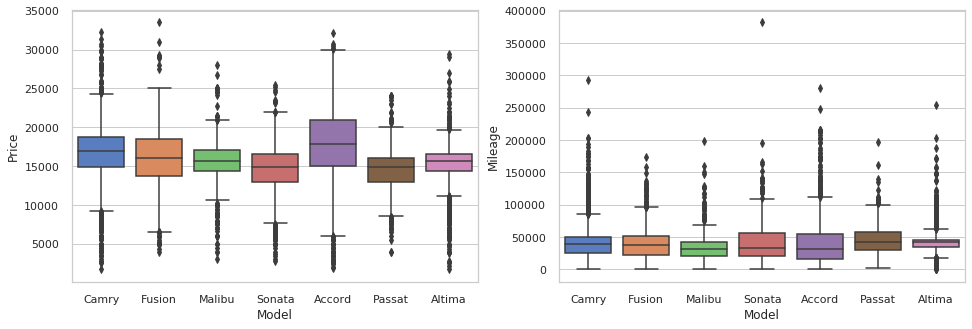

In [14]:
fig = plt.figure(figsize=(16,5))
ax1, ax2 = fig.subplots(1, 2)
sns.boxplot(x="Model", y="Price", data=car_listings,  ax=ax1)
sns.boxplot(x="Model", y="Mileage", data=car_listings, ax=ax2)

## Plotting and model training functions

In [0]:
def plot(make, df=None, plt_type='scatter'):
  if df is None:
    print("data frame none")
    df = car_listings
  fig = plt.figure(figsize=(12,5))
  axes = fig.subplots(1,2)

  for index, column in enumerate(['Mileage', 'Year']):
    # axes[index].set_xticklabels(labels[column])
    if plt_type == 'scatter':
      sns.scatterplot(df[(df.Make == make)][column],df[df.Make == make]['Price'], ax=axes[index])
    elif plt_type == 'kde':
      sns.kdeplot(df[column], ax=axes[index],shade=True)
    axes[index].set_title(make)

In [0]:
def transform(series, transformation):
  '''Transform a series into another series by centering, 
  standardizing or using a custome function
  '''
  if callable(transformation):
    return transformation(series)
  elif transformation == 'center':
    return series - np.mean(series)
  elif transformation == 'standardize':
    return (series - np.mean(series))/np.std(series)

def train_linear_regression(train, regularizer=None):
  ''' Takes in the training set 'train' and performs LASSO(ElasticNet)
  in two steps. First LASSO(ElasticNet) Cross Validation is used to 
  select the alpha regularization hyper-parameter that optimizes 
  between OLS and regularization costs. Second, this parameter is 
  used to train a model'''

  if regularizer is None:
    model = LinearRegression().fit(train.drop('Price', axis=1), train.Price)

  elif regularizer == 'e':
    elasticnet_cv = ElasticNetCV(cv=5, random_state=0, l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
    elasticnet_cv.fit(train.drop('Price', axis=1), train.Price)

    model = ElasticNet(alpha=elasticnet_cv.alpha_, l1_ratio=elasticnet_cv.l1_ratio_, random_state=0)
    model.fit(train.drop('Price', axis=1), train.Price)
  elif regularizer == 'r':
    ridge_cv = RidgeCV(cv=10)
    ridge_cv.fit(train.drop('Price', axis=1), train.Price)

    model = Ridge(random_state=0,alpha=ridge_cv.alpha_)
    model.fit(train.drop('Price', axis=1), train.Price)
  else:
    lasso_cv = LassoCV( cv=10, random_state=0)
    lasso_cv.fit(train.drop('Price', axis=1), train.Price)

    model = Lasso(random_state=0,alpha=lasso_cv.alpha_)
    model.fit(train.drop('Price', axis=1), train.Price)
  return model

def train_test_plot(dataframe, columns, visualize=True, return_test_set=False, regularizer=None):
  '''Splits the data set into training and test sets, 
  trains a regression model, and visualizes the residuals (if vizualise is True)
  '''
  train, test = train_test_split(dataframe[columns],shuffle=True)
  model = train_linear_regression(train, regularizer)

  # Price should be the last in the 'columns' list!
  predicted = dataframe[columns[:-1]].dot(model.coef_) + model.intercept_
  r2_score = model.score(test[columns[:-1]], test['Price'])

  if visualize:
    residual_visualizer = ResidualsPlot(model)

    residual_visualizer.fit(train[columns[:-1]], train['Price'])  
    residual_visualizer.score(test[columns[:-1]], test['Price'])  
    residual_visualizer.poof() 
  if return_test_set:
    return model, test
  return model

In [0]:
def performance(data, columns, rep=10, regularizer=None):
  '''A function for checking the performance of models by 
  repeatedly training the models.
  '''
  result = {
      'coef':[],
      'intercept':[],
      'score':[],
      'RMSE':[]
  }


  for _ in range(rep):
    model, test_set = train_test_plot(data, columns, visualize=False, return_test_set=True, regularizer=regularizer)
    residuals = model.predict(data[columns].drop('Price', axis=1))  -  data['Price']

    result['coef'].append(model.coef_)
    result['intercept'].append(model.intercept_)
    result['score'].append(model.score(test_set.drop('Price', axis=1), test_set.Price))
    result['RMSE'].append(np.sqrt(np.sum(residuals **2) / data.shape[0]))
  coef_means = np.mean(np.array(result['coef']), axis=0)
  coef_std = np.std(np.array(result['coef']), axis=0, ddof=len(result['coef']) - 1)

  intercept_mean = np.mean(result['intercept'])
  intercept_std = np.std(result['intercept'], ddof=len(result['intercept']) - 1)

  score_mean = np.mean(result['score'])
  score_std = np.std(result['score'], ddof=len(result['score']) - 1)

  RMSE_mean = np.mean(result['RMSE'])
  RMSE_std = np.std(result['RMSE'], ddof=len(result['RMSE']) - 1)

  stats = {
      'coef_means': coef_means,
      'coef_CI': list(zip(coef_means - 1.96 * coef_std/np.sqrt(len(result['coef'])), coef_means + 1.96 * coef_std/np.sqrt(len(result['coef'])))),
      'Intercept': {
          'mean': intercept_mean,
          'CI': [intercept_mean - 1.96 * intercept_std/np.sqrt(len(result['intercept'])), intercept_mean + 1.96 * intercept_std/np.sqrt(len(result['intercept']))]
      },
      'R2_on_testset': {
          'mean': score_mean,
          'CI': [score_mean - 1.96 * score_std/np.sqrt(len(result['score'])), score_mean + 1.96 * score_std/np.sqrt(len(result['score']))]
          },
      'RMSE': {
          'mean': RMSE_mean,
          'CI': [RMSE_mean - 1.96 *RMSE_std/np.sqrt(len(result['RMSE'])), RMSE_mean + 1.96 *RMSE_std/np.sqrt(len(result['RMSE']))]
      }
  }
  return stats

## 1. Regression model for Toyota Camry 

### 1.1 Initial analysis

In [18]:
toyota = car_listings[(car_listings.Make == 'Toyota')].copy()
toyota.sort_values(by='Mileage')
toyota.reset_index(inplace=True,drop=True)
toyota.describe().applymap(lambda x: int(x))

,Year,Price,Mileage
count,1317,1317,1317
mean,2016,16438,44794
std,2,4143,32001
min,1998,1700,115
25%,2016,14900,25373
50%,2017,16990,39077
75%,2018,18699,49637
max,2019,32200,293258


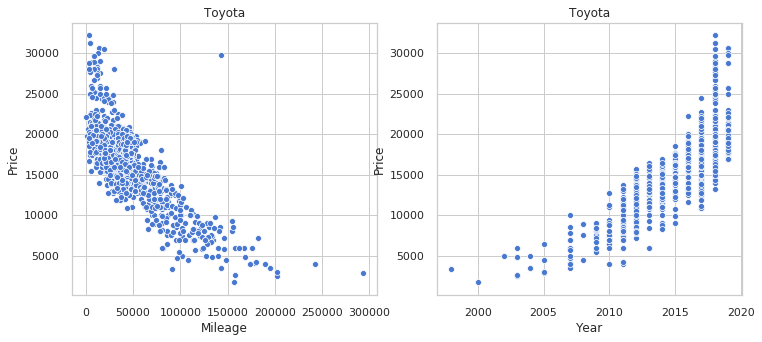

In [19]:
plot('Toyota', toyota)

In [20]:
toyota.corr()

,Year,Price,Mileage
Year,1.000000,0.804108,-0.749551
Price,0.804108,1.000000,-0.782014
Mileage,-0.749551,-0.782014,1.000000


#### Check botton and top ends of the ***Mileage*** and ***Year*** columns for outliers

In [21]:
# Mileage
display(toyota.sort_values(by='Mileage').head())
display(toyota.sort_values(by='Mileage').tail())
display([toyota.Mileage.mean() - (3*toyota.Mileage.std()), toyota.Mileage.mean() + (3*toyota.Mileage.std())])

,Year,Make,Model,Detailed_model,Price,Mileage,Website
735,2019,Toyota,Camry,SE,22100.0,115,ED
787,2019,Toyota,Camry,L,19797.0,1193,ED
738,2019,Toyota,Camry,SE,20691.0,2300,ED
1191,2019,Toyota,Camry,LE,19489.0,2870,ED
736,2018,Toyota,Camry,XSE,32200.0,2893,ED


,Year,Make,Model,Detailed_model,Price,Mileage,Website
632,2007,Toyota,Camry,SE,3494.0,194576,ED
811,2003,Toyota,Camry,XLE,2500.0,202790,ED
1274,2005,Toyota,Camry,LE,2995.0,202840,ED
1300,2010,Toyota,Camry,LE,3995.0,242756,ED
353,2005,Toyota,Camry,LE I4,2845.0,293258,TC


[-51208.90453560975, 140797.563609262]

We have a handful of cars that are driven more than 3 times the standard deviation of mileage. These could be problematic when trying to fit a regression model as linear regression can be affected by outliers (esp. large ones)

In [22]:
outliers = toyota[toyota.Mileage > toyota.Mileage.mean() + (3*toyota.Mileage.std())]
print(outliers.shape)

(26, 7)


In [23]:
# These 'outliers' are not that many so we can safely drop them
toyota.drop(outliers.index, inplace=True)
toyota.describe()

,Year,Price,Mileage
count,1291.000000,1291.000000,1291.000000
mean,2016.312936,16648.049574,42193.724245
std,2.560216,3841.209513,26071.213471
min,1998.000000,3387.000000,115.000000
25%,2016.000000,14995.000000,25019.500000
50%,2017.000000,16995.000000,38668.000000
75%,2018.000000,18736.000000,48038.500000
max,2019.000000,32200.000000,140630.000000


In [24]:
# Doing the same thing for 'Year'
display(toyota.sort_values(by='Year').head())
display(toyota.sort_values(by='Year').tail())
display([toyota.Year.mean() - (3*toyota.Year.std()), toyota.Year.mean() + (3*toyota.Year.std())])

,Year,Make,Model,Detailed_model,Price,Mileage,Website
321,1998,Toyota,Camry,LE I4,3387.0,90940,TC
320,2002,Toyota,Camry,LE I4,4995.0,101315,TC
17,2003,Toyota,Camry,LE I4,5995.0,81881,TC
377,2003,Toyota,Camry,XLE I4,4800.0,133325,TC
284,2004,Toyota,Camry,LE I4,4923.0,127211,TC


,Year,Make,Model,Detailed_model,Price,Mileage,Website
545,2019,Toyota,Camry,LE,19000.0,3111,ED
783,2019,Toyota,Camry,LE,18299.0,14640,ED
1166,2019,Toyota,Camry,L,19099.0,11716,ED
702,2019,Toyota,Camry,L,18995.0,31647,ED
516,2019,Toyota,Camry,LE,18572.0,17737,TC


[2008.6322862205623, 2023.9935851969437]

In [25]:
outliers_year = toyota[toyota.Year < toyota.Year.mean() - (3*toyota.Year.std())]
print(outliers_year.shape)

(20, 7)


In [0]:
toyota.drop(outliers_year.index, inplace=True)

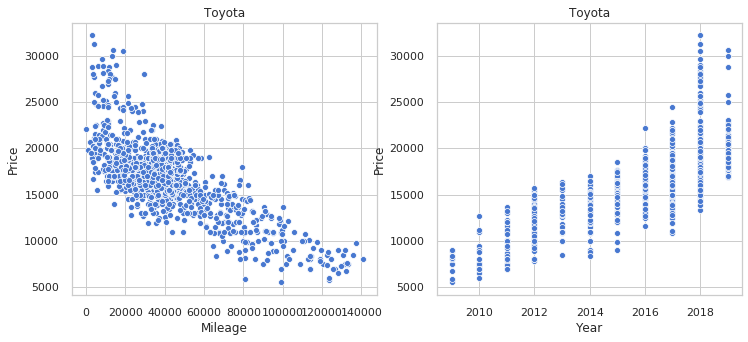

In [27]:
# Plot Mileage-vs-Price and Year-vs-Price after removing outliers
plot('Toyota', toyota)

#### Histograms of ***Mileage***, ***Year*** and ***Price*** columns

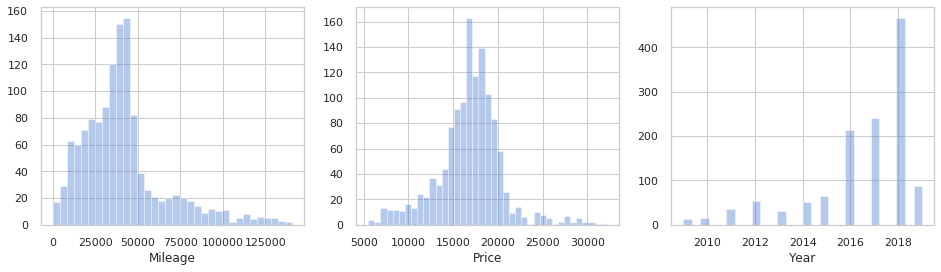

In [28]:
fig = plt.figure(figsize=(16, 4))
axes = fig.subplots(1,3)
sns.distplot(toyota.Mileage, kde=False, ax=axes[0])
sns.distplot(toyota.Price, kde=False, ax=axes[1])
sns.distplot(toyota.Year, kde=False, ax=axes[2])

#### Average price of Toyota Camry by trim level

In [29]:
toyota.groupby(by='Detailed_model').agg({'Mileage':['count', 'mean'], 'Price':[ 'mean']})

Mileage                        Price
                              count           mean          mean
Detailed_model                                                  
2014 Hybrid                       2   64846.500000  13241.000000
2014 L I4                         1   63009.000000  10980.000000
2014 LE I4                       10   72422.400000  12095.200000
2014 SE I4                        4   67080.750000  12883.500000
2014 SE Sport I4                  1   72341.000000  14500.000000
2014 SE V6                        1   70225.000000  16130.000000
2014 XLE I4                       2   52783.000000  16199.000000
2014 XLE V6                       1   31523.000000  16500.000000
Base                              1  113667.000000   6946.000000
Hybrid                           22   46411.318182  18261.818182
I4                                2  106666.000000   8721.500000
L                                42   31905.142857  17637.000000
L I4                             11   34250.818182  17218.090909
LE                              362   39921.212707  16472.049724
LE FWD                            1    9044.000000  19300.000000
LE I4                           164   39268.067073  15745.451220
LE V6                             4  101604.000000   8745.750000
SE                              308   43556.477273  16937.506494
SE I4                           133   41298.338346  16368.278195
SE Limited Edition                1   47460.000000  14600.000000
SE Special Edition I4             1   40407.000000  17500.000000
SE Sport Limited Edition I4       1   92561.000000  10990.000000
SE Used                           1   25467.000000  14699.000000
SE V6                             6   72821.666667  12547.500000
Special Edition                   2   32703.500000  14799.500000
XLE                              62   44721.790323  16677.612903
XLE I4                           41   35039.146341  18122.878049
XLE V6                           15   59629.200000  15694.400000
XSE                              38   27263.605263  21654.210526
XSE I4                           20   30296.950000  20773.600000
XSE V6                           11   14936.545455  28473.454545

### 1.2 Exploring features
---

In [0]:
toyota['Year_ctr'] = transform(toyota.Year, 'center')
toyota['Year_ctr_2019'] = 2019 - toyota.Year
toyota['Mileage_ctr'] = transform(toyota.Mileage, 'center')
toyota['Year_std'] = transform(toyota.Year, 'standardize')
toyota['Year_SQ_std'] = transform((toyota.Year**2), 'standardize')
toyota['Year_SQ_ctr'] = transform((toyota.Year**2), 'center')
toyota['Year_Quad2_std'] = transform(18.92 * toyota.Year**2, 'standardize')
toyota['Year_Quad1_std'] = transform(7.5e4 * toyota.Year, 'standardize')
toyota['Mileage_std'] = transform(toyota.Mileage, 'standardize')
toyota['Mileage_SQRT_std'] = transform(transform(toyota.Mileage, np.sqrt) , 'standardize')
toyota['Mileage_log'] = np.log2(toyota.Mileage)
toyota['Mileage_log_std'] = transform(transform(toyota.Mileage, np.log2), 'standardize')

# Encoding trim-level as a dummy variable
toyota['XLE'] = [1 if entry else 0 for entry in toyota.Detailed_model.str.contains('XLE', na=False)] 
toyota['XSE'] = [1 if entry else 0 for entry in toyota.Detailed_model.str.contains('XSE', na=False)] 
toyota['Hybrid'] = [1 if entry else 0 for entry in toyota.Detailed_model.str.contains('Hybrid', na=False)] 

---

### 1.3 First attempt: Price as a simple linear function of Mileage

$$P_i = w_0 + w_1 M_i$$

where $P_i$ and $M_i$ are the $i^{th}$ price and standardized mileage <br/>
and $w_0$ and $w_1$ are the intercept and weight to be 'learned' by the model

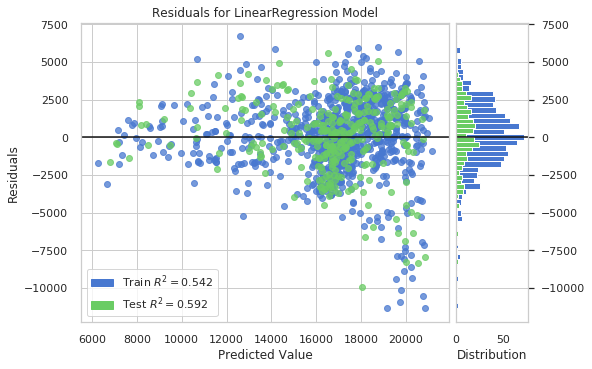

 
w_0 = 16817.27212832387, w_1 = -2639.661329014988


In [31]:
simple_linear_model = train_test_plot(toyota, ['Mileage_std', 'Price'])
print(" ")
print('w_0 = {}, w_1 = {}'.format(simple_linear_model.intercept_, simple_linear_model.coef_[0]))

The coefficient tells us that for every standardad deviation increase <br/>
in mileage (i.e. roughly for every 31K mileage) the price of a Toyota camry drops by 2699 dollars. 

However the residuals show strong ***heteroscedasticity*** that needs fixing. <br/>
Note that for a simple regression, our model has a high $R^2$ score but before <br/> considering model performance seriously, let us first try to fix the heteroscedasticity

Our model systematically under-predicted the price of the expensive cars.<br/>
As shown in the cell below, these cars also happen to have the least <br/>
mileage.

A linear relationship between mileage and price performs relatively well<br/>
for cars that are driven long enough. However, for those cars that reside <br/>
on the boundaries of being "New" and "Used" (i.e. cars whose mileage is <br/>
within the first few thousands), the effect of other factors is stronger <br/>than mileage.

#### Mileage-vs-Price and Year-vs-Price - two regions of mileage

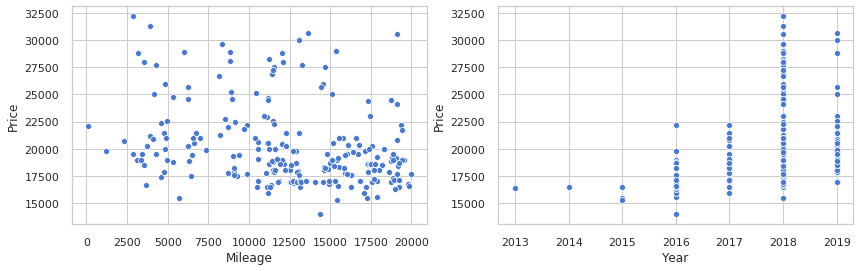

In [32]:
fig = plt.figure(figsize=(14, 4))
axes = fig.subplots(1,2)
sns.scatterplot(toyota[toyota.Mileage < 20000].Mileage, toyota.Price, ax=axes[0])
sns.scatterplot(toyota[toyota.Mileage < 20000].Year, toyota.Price, ax=axes[1])

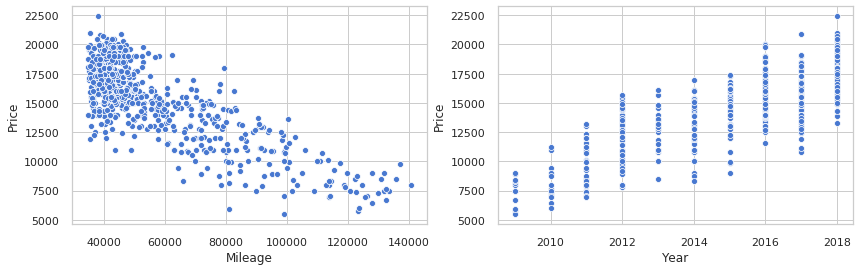

In [33]:
fig = plt.figure(figsize=(14, 4))
axes = fig.subplots(1,2)
sns.scatterplot(toyota[toyota.Mileage > 35000].Mileage, toyota.Price, ax=axes[0])
sns.scatterplot(toyota[toyota.Mileage > 35000].Year, toyota.Price, ax=axes[1])

#### Check if Squareroot transforming ***Mileage*** yields a better model

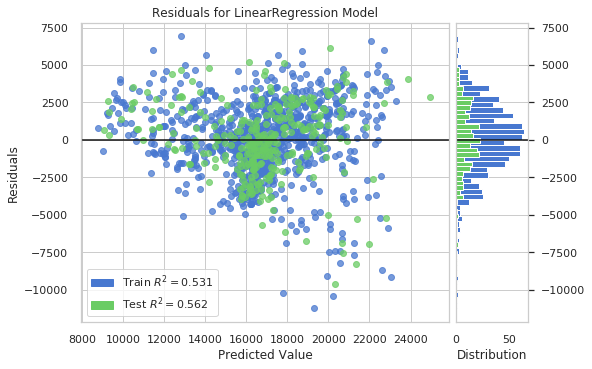

In [34]:
model = train_test_plot(toyota, ['Mileage_SQRT_std', 'Price'])
residuals = model.predict(toyota[['Mileage_SQRT_std']])  -  toyota['Price']

#### Test multicolinearity between ***Mileage*** and ***Year*** using VIF

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_test = toyota[['Mileage', 'Year']].copy()
vif_test['Intercept'] = np.ones(vif_test.shape[0])

pd.Series([variance_inflation_factor(vif_test.values, i) for i in range(vif_test.shape[1])], index=vif_test.columns)

Mileage      1.983026e+00
Year         1.983026e+00
Intercept    1.705215e+06
dtype: float64

###  1.4 Using ***Year*** and trim-level as features along with ***Mileage***

$$P_i = w_0 + w_1 f(M_i) + w_2 g(Y_i) + w_3 1_{\{XLE_i\}} + w_4 1_{\{XSE_i\}} + w_5 1_{\{Hybrid_i\}},$$

where $M_i$ and $Y_i$ are the *Mileage* and *Year* of the $i^{th}$ car,
$f$ and $g$ are some transformation functions, and $1_{\{a_i\}}$ is an indicator function on condition $a_i$.

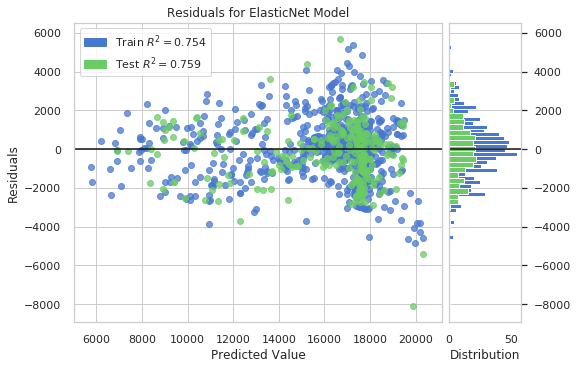

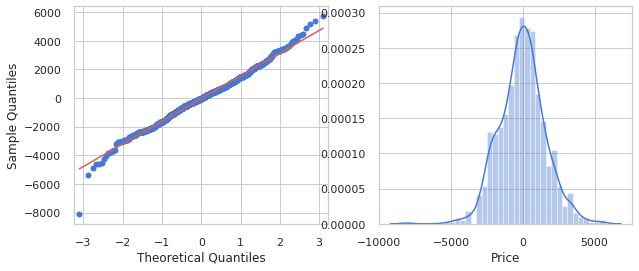

In [36]:
columns = ['Mileage_std', 'Year_std','XLE' ,'XSE', 'Hybrid','Price']
rows = toyota[toyota.Mileage > 20000]
model = train_test_plot(rows, columns, regularizer='e')
residuals = model.predict(rows[columns[:-1]])  -  rows['Price']
fig = plt.figure(figsize=(10,4)); axes = fig.subplots(1,2);
qqplot(residuals, line='r',ax=axes[0]); 
sns.distplot(residuals, ax=axes[1]);

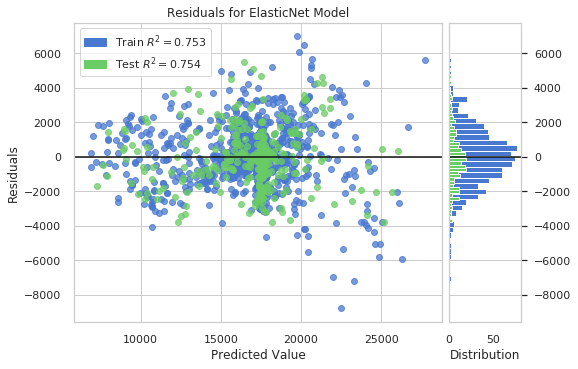

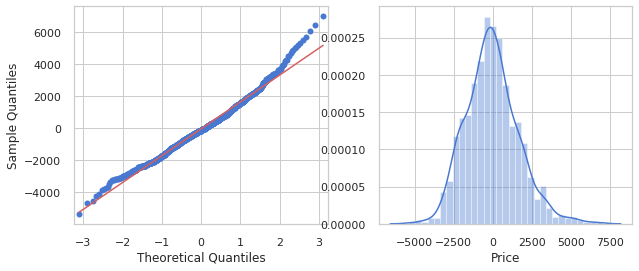

In [37]:
columns = ['Mileage_log', 'Year_ctr_2019','XLE' ,'XSE', 'Hybrid','Price']
model = train_test_plot(toyota, columns, regularizer='e')
residuals = model.predict(rows[columns[:-1]])  -  rows['Price']
fig = plt.figure(figsize=(10,4)); axes = fig.subplots(1,2);
qqplot(residuals, line='r',ax=axes[0]); 
sns.distplot(residuals, ax=axes[1]);

### 1.5 Cook's distance to identify and remove influential data points and refit the model

/usr/local/lib/python3.6/dist-packages/yellowbrick/regressor/influence.py:183: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  self.distance_, linefmt=self.linefmt, markerfmt=self.markerfmt


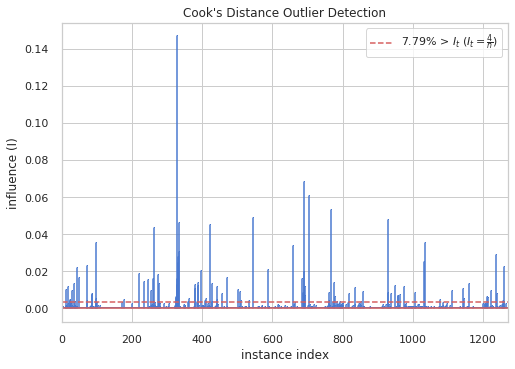

In [38]:
X, y = toyota[['Mileage_std', 'Year_std','XLE' ,'XSE', 'Hybrid']], toyota.Price

# Instantiate and fit the visualizer
cooks_dist_viz = CooksDistance()
cooks_dist_viz.fit(X, y)
cooks_dist_viz.poof()

In [39]:
toyota[(cooks_dist_viz.distance_ >= 0.02)].shape

(21, 22)

#### Removing influential observations having Cook's distance >= 0.02 and refitting model

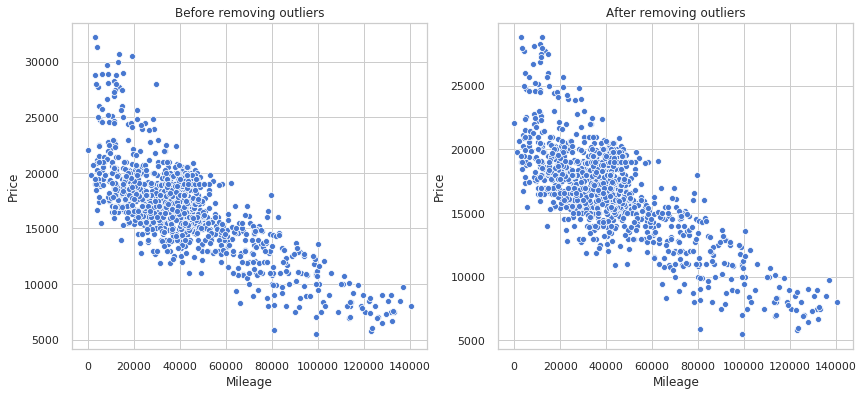

In [40]:
toyota_exc_outliers = toyota[(cooks_dist_viz.distance_ < 0.02)]
fig = plt.figure(figsize=(14,6))
ax1, ax2 = fig.subplots(1, 2)
sns.scatterplot('Mileage', 'Price', data=toyota,ax=ax1)
ax1.set_title('Before removing outliers')
sns.scatterplot('Mileage', 'Price', data=toyota_exc_outliers,ax=ax2)
ax2.set_title('After removing outliers');

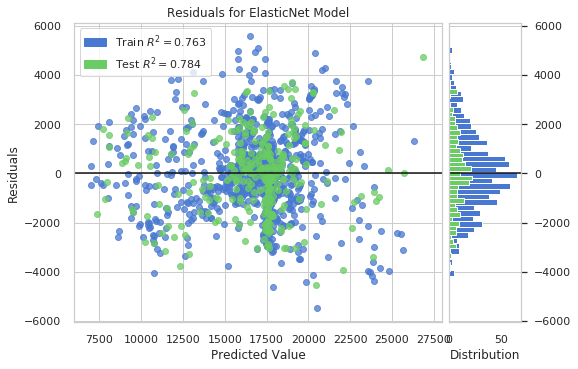

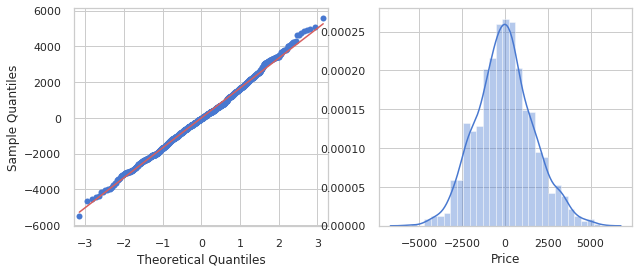

In [41]:
columns = ['Mileage_log', 'Year_ctr_2019','XLE' ,'XSE', 'Hybrid','Price']
model = train_test_plot(toyota_exc_outliers, columns, regularizer='e')
residuals = model.predict(toyota_exc_outliers[columns[:-1]])  -  toyota_exc_outliers['Price']
fig = plt.figure(figsize=(10,4)); axes = fig.subplots(1,2);
qqplot(residuals, line='r',ax=axes[0]); 
sns.distplot(residuals, ax=axes[1]);

Our model can reasonably be assumed to satisfy the [assumptions](https://www.statisticssolutions.com/assumptions-of-linear-regression/) of linear regression.

### 1.6 Model performance

In [42]:
result = performance(toyota_exc_outliers,['Mileage_std', 'Year_std', 'XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [16311.4659124085, 16411.275847715024],
               'mean': 16361.37088006176},
 'R2_on_testset': {'CI': [0.734542933462897, 0.8171985686026815],
                   'mean': 0.7758707510327892},
 'RMSE': {'CI': [1619.1796416853094, 1624.449932385412],
          'mean': 1621.8147870353607},
 'coef_CI': [(-1288.6170336129767, -1158.4557320370104),
             (1731.7019048699033, 1877.550618405079),
             (1174.6090135904576, 1599.9402815543651),
             (4347.608197907842, 5247.211837816899),
             (2134.607121954781, 2712.7614224318413)],
 'coef_means': array([-1223.53638282,  1804.62626164,  1387.27464757,  4797.41001786,
        2423.68427219])}


In [43]:
result = performance(toyota_exc_outliers,['Mileage_log', 'Year_ctr_2019', 'XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [32083.08030289106, 34507.00781130207],
               'mean': 33295.044057096566},
 'R2_on_testset': {'CI': [0.720503266692004, 0.805035529700948],
                   'mean': 0.762769398196476},
 'RMSE': {'CI': [1661.62940541367, 1668.6073455589037],
          'mean': 1665.1183754862868},
 'coef_CI': [(-1040.9499616298804, -876.6357283553839),
             (-1018.690999595366, -957.7067837756614),
             (1158.2190383848956, 1624.5966788991582),
             (4112.669957910954, 5014.878444756281),
             (2041.6852490632596, 2750.627829462915)],
 'coef_means': array([-958.79284499, -988.19889169, 1391.40785864, 4563.77420133,
       2396.15653926])}


### 1.7 Final Toyota Camry model


In [44]:
from collections import namedtuple

final_model = namedtuple('model', 'coef_ intercept_')
toyota_model = final_model(result['coef_means'], result['Intercept']['mean'])

print('Final model for Toyota Camry: \n\tCoefficients = {} \n\tIntercept = {}'.format(toyota_model.coef_, toyota_model.intercept_))

Final model for Toyota Camry: 
	Coefficients = [-958.79284499 -988.19889169 1391.40785864 4563.77420133 2396.15653926] 
	Intercept = 33295.044057096566


### 1.8 3D Visualization of the regression model

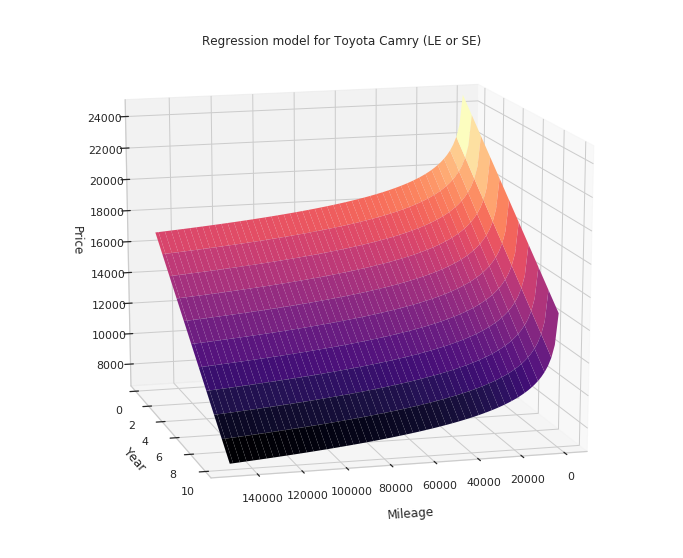

In [45]:
from mpl_toolkits import mplot3d

def f(model, m, y, *args):
  return model.coef_.dot(np.array([np.log2(m), y, *args])) + model.intercept_

mileage = np.linspace(500, 150000, 100)
year = range(11)

X, Y = np.meshgrid(mileage, year)

Z = f(toyota_model, X, Y, 0, 0, 0)
fig = plt.figure(figsize=(12,10))
ax=fig.add_subplot(111,projection='3d')

ax.plot_surface(X,Y,Z, cmap='magma',edgecolor='none')

ax.set_title('Regression model for Toyota Camry (LE or SE)');
ax.set_xlabel('\nMileage', linespacing=3.2)
ax.set_ylabel('\nYear')
ax.set_zlabel('\nPrice', linespacing=3.2);
ax.view_init(15, 75)

## 2. Regression model for Honda Accord

### 2.1 Initial analysis

In [46]:
honda = car_listings[(car_listings.Make == 'Honda')].copy()
honda.sort_values(by='Mileage', inplace=True)
honda.reset_index(inplace=True,drop=True)
honda.describe().applymap(lambda x: int(x))

,Year,Price,Mileage
count,1058,1058,1058
mean,2015,17660,42601
std,2,5576,39149
min,2002,1855,604
25%,2015,14972,16419
50%,2017,17792,31845
75%,2018,20988,54455
max,2019,32080,279638


In [47]:
honda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 7 columns):
Year              1058 non-null int64
Make              1058 non-null object
Model             1058 non-null object
Detailed_model    1056 non-null object
Price             1058 non-null float64
Mileage           1058 non-null int64
Website           1058 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 58.0+ KB


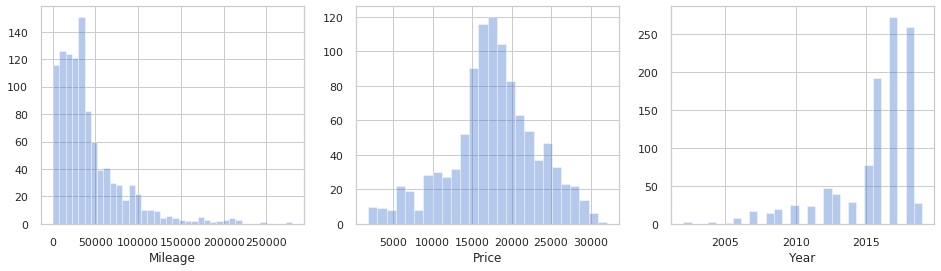

In [48]:
fig = plt.figure(figsize=(16, 4))
axes = fig.subplots(1,3)
sns.distplot(honda.Mileage, kde=False, ax=axes[0])
sns.distplot(honda.Price, kde=False, ax=axes[1])
sns.distplot(honda.Year, kde=False, ax=axes[2])

### 2.2 Checking tail ends of *Mileage* and *Year* for outliers

In [49]:
display(honda.head())
display(honda.tail())
display([honda.Mileage.mean() - 3 * honda.Mileage.std(), honda.Mileage.mean() + 3 * honda.Mileage.std()])

,Year,Make,Model,Detailed_model,Price,Mileage,Website
0,2018,Honda,Accord,EX-L,30100.0,604,ED
1,2018,Honda,Accord,LX,22100.0,825,ED
2,2019,Honda,Accord,Sport 2.0T,27888.0,898,TC
3,2019,Honda,Accord,LX 1.5T,21984.0,1113,TC
4,2019,Honda,Accord,EX,24396.0,1119,ED


,Year,Make,Model,Detailed_model,Price,Mileage,Website
1053,2007,Honda,Accord,LX,2388.0,214844,ED
1054,2007,Honda,Accord,LX Sedan I4,2488.0,214844,TC
1055,2009,Honda,Accord,LX Sedan I4,3988.0,215049,TC
1056,2004,Honda,Accord,EX,1855.0,248143,ED
1057,2005,Honda,Accord,EX V-6,1995.0,279638,ED


[-74848.78084913114, 160050.81109487783]

In [50]:
outliers = honda[honda.Mileage > honda.Mileage.mean() + 3*honda.Mileage.std()]
outliers.shape

(26, 7)

In [0]:
honda.drop(outliers.index, inplace=True)

In [52]:
display(honda.sort_values(by="Year").head())
display(honda.sort_values(by="Year").tail())
display([honda.Year.mean() - 3 * honda.Year.std(), honda.Year.mean() + 3 * honda.Year.std()])

,Year,Make,Model,Detailed_model,Price,Mileage,Website
1022,2002,Honda,Accord,VP with Side Airbags Sedan,2688.0,138375,TC
1031,2006,Honda,Accord,EX-L Sedan,4995.0,158697,TC
945,2006,Honda,Accord,EX-L Sedan,7495.0,91948,TC
1025,2006,Honda,Accord,EX-L V6 with Navigation Sedan,6499.0,141303,TC
976,2006,Honda,Accord,EX-L Sedan,6991.0,100835,TC


,Year,Make,Model,Detailed_model,Price,Mileage,Website
32,2019,Honda,Accord,EX-L,26399.0,3540,ED
35,2019,Honda,Accord,Touring,30194.0,3627,ED
40,2019,Honda,Accord,EX-L,26385.0,3911,ED
15,2019,Honda,Accord,EX-L,28440.0,2067,ED
96,2019,Honda,Accord,Sport,22768.0,6927,ED


[2008.0193203096405, 2023.6957959694291]

In [53]:
outliers_year = honda[honda.Year < honda.Year.mean() - 3*honda.Year.std()]
outliers_year.shape

(26, 7)

In [0]:
honda.drop(outliers_year.index, inplace=True)

In [55]:
honda.describe().applymap(int)

,Year,Price,Mileage
count,1006,1006,1006
mean,2016,18306,36710
std,2,4899,28109
min,2009,5490,604
25%,2015,15487,15759
50%,2017,17995,30396
75%,2018,21167,48762
max,2019,32080,153341


### 2.3 Histograms, Plots and VIF

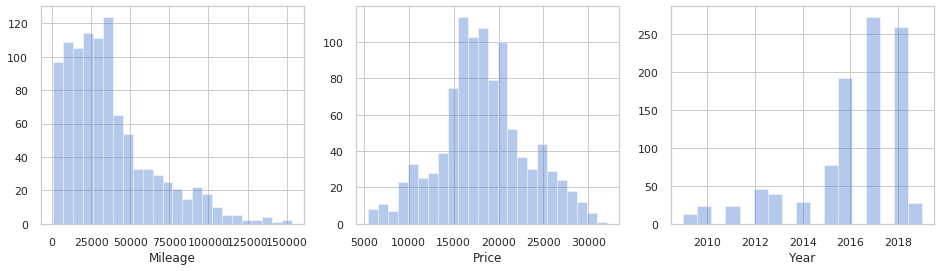

In [56]:
fig = plt.figure(figsize=(16, 4))
axes = fig.subplots(1,3)
sns.distplot(honda.Mileage, kde=False, ax=axes[0])
sns.distplot(honda.Price, kde=False, ax=axes[1])
sns.distplot(honda.Year, kde=False, ax=axes[2])

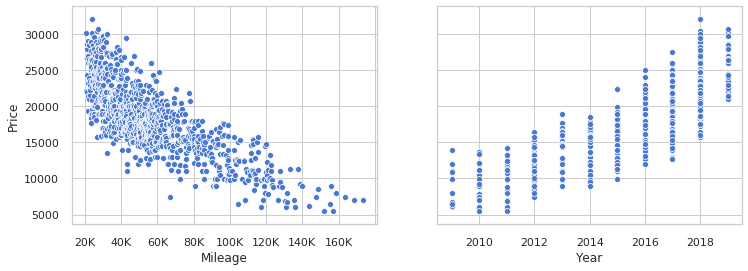

In [57]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4),sharey=True)
sns.scatterplot(honda.Mileage, honda.Price, ax=ax1)
ax1.set_xticklabels(['0','20K', '40K', '60K', '80K', '100K', '120K', '140K','160K']);
sns.scatterplot(honda.Year, honda.Price, ax=ax2);

In [58]:
vif_test = honda[['Mileage', 'Year']].copy()
vif_test['Intercept'] = np.ones(vif_test.shape[0])

pd.Series([variance_inflation_factor(vif_test.values, i) for i in range(vif_test.shape[1])], index=vif_test.columns)

Mileage      2.599195e+00
Year         2.599195e+00
Intercept    2.156363e+06
dtype: float64

### 2.4 Exploring features

---

In [0]:
honda['Year_ctr'] = transform(honda.Year, 'center')
honda['Year_ctr_2019'] = 2019 - honda.Year 
honda['Year_ctr_2019_SQ'] = honda.Year_ctr_2019**2
honda['Year_std'] = transform(honda.Year, 'standardize')
honda['Year_SQ_std'] = transform(honda.Year **2, 'standardize')
honda['Mileage_ctr'] = transform(honda.Mileage, 'center')
honda['Mileage_SQRT_std'] = transform(transform(honda.Mileage, np.sqrt), 'standardize')
honda['Mileage_std'] = transform(honda.Mileage, 'standardize')
honda['Mileage_log'] = transform(honda.Mileage, np.log2)
honda['LX'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('LX', na=False)]
honda['ALL_EX'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('EX', na=False)]
honda['EXL'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('EX-L', na=False)]
honda['EX'] = [1 if (ex == 1) & (exl == 0) else 0 for ex, exl in zip(honda.ALL_EX.to_list(), honda.EXL.to_list())]
honda['Sport'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('Sport', na=False)]
honda['Touring'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('Touring', na=False)]

---

### 2.5 Initial model: Simple linear regression

$P_i = w_0 + w_1 f(M_i)$

where $P_i$ = Price of Honda Accord car $i$  
      $M_i$ = Mileage of Honda Accord car $i$    
      $w_0$ = Intercept of the model  
      $w_1$ = Slope (weight) w.r.t. mileage  
      $f$ is a standardization function


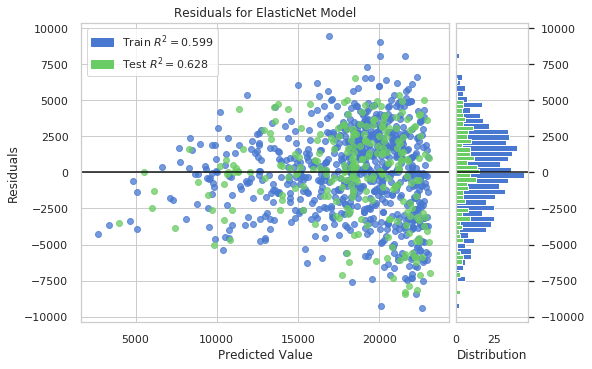

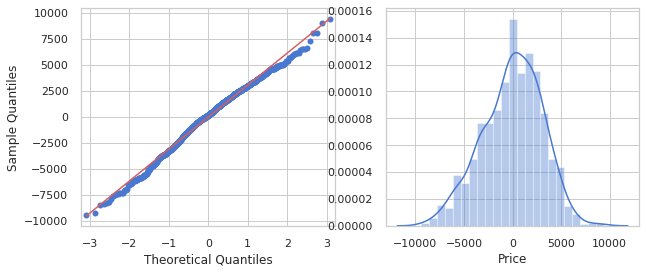

In [60]:

columns = ['Mileage_std','Price']
data = honda[columns]
model = train_test_plot(data,columns, regularizer='e')
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(10,4));
axes = fig.subplots(1,2);
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1]);

### 2.6 Including *Trim level* and *Year* in the regression model

$$P_i = w_0 + w_1 f(M_i) + w_2 g(Y_i) + w_3 1_{\{EX_i\}} + w_4 1_{\{EXL_i\}} + w_5 1_{\{Sport_i\}} + w_5 1_{\{Touring_i\}},$$

where $M_i$ and $Y_i$ are the *Mileage* and *Year* of the $i^{th}$ car,
$f$ and $g$ are some transformation functions, and $1_{\{a_i\}}$ is an indicator function on condition $a_i$.

In [61]:
display(honda[honda.Detailed_model.str.contains('Sport',na=False)].shape)
display(honda[honda.Detailed_model.str.contains('LX',na=False)].shape)
display(honda[honda.Detailed_model.str.contains('Touring',na=False)].shape)
display(honda[honda.Detailed_model.str.contains('EX',na=False)].shape)

(264, 22)

(290, 22)

(66, 22)

(367, 22)

In [62]:
display(honda[honda.Detailed_model.str.contains('LX',na=False)].Price.mean())
display(honda[honda.Detailed_model.str.contains('EX',na=False)].Price.mean())
display(honda[honda.Detailed_model.str.contains('Sport',na=False)].Price.mean())
display(honda[honda.Detailed_model.str.contains('Touring',na=False)].Price.mean())

16053.124137931034

18422.623978201635

19148.81818181818

25891.030303030304

#### $f$, $g$ standardization functions

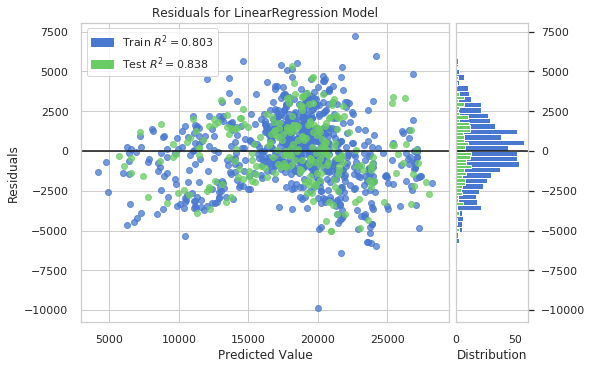

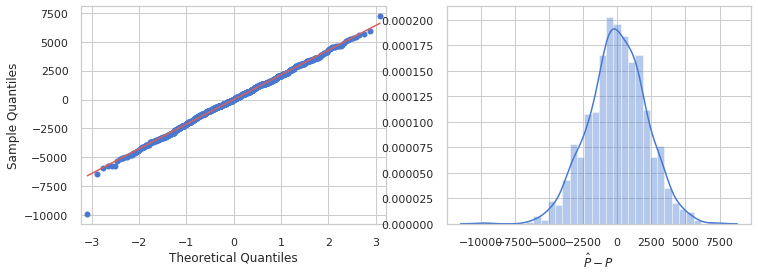

In [63]:
columns = ['Mileage_std', 'Year_std', 'EX', 'EXL', 'Sport', 'Touring', 'Price']
data = honda[columns]
model = train_test_plot(data,columns)
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(12,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
axes[1].set_xlabel('$\hat{P} - P$');

#### $f$ = log2 and $g$ = centering (around 2019) functions 

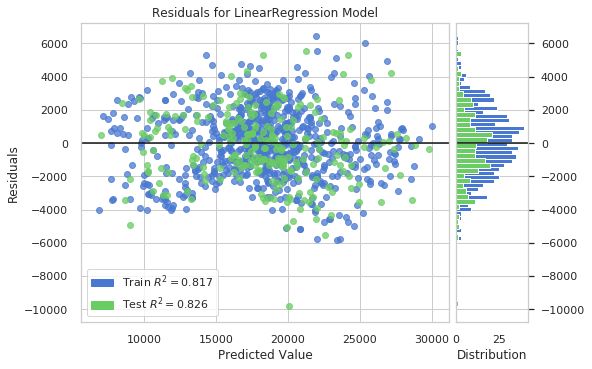

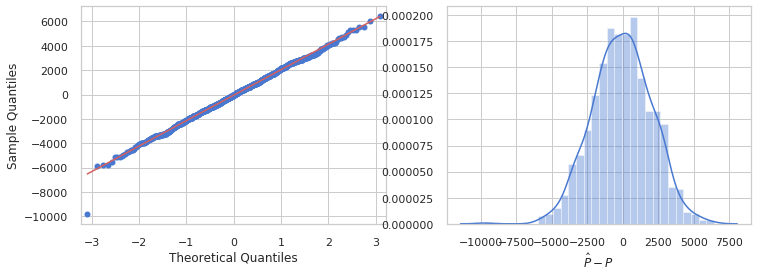

In [64]:
columns = ['Mileage_log', 'Year_ctr_2019', 'EX', 'EXL', 'Sport', 'Touring', 'Price']
model = train_test_plot(honda,columns)
residuals = model.predict(honda[columns].drop('Price', axis=1))  -  honda.Price
fig = plt.figure(figsize=(12,4));axes = fig.subplots(1,2);
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1]);axes[1].set_xlabel('$\hat{P} - P$');

### 2.7 Removing influential (outlier) observations and refitting model 

/usr/local/lib/python3.6/dist-packages/yellowbrick/regressor/influence.py:183: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  self.distance_, linefmt=self.linefmt, markerfmt=self.markerfmt


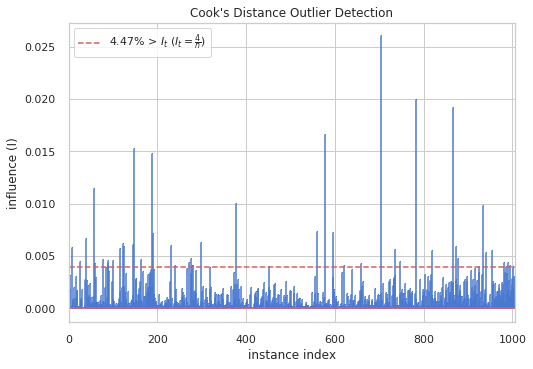

In [65]:
X, y = honda[['Mileage_log', 'Year_ctr_2019', 'EX', 'EXL', 'Sport', 'Touring']], honda.Price

# Instantiate and fit the visualizer
cooks_dist_viz = CooksDistance()
cooks_dist_viz.fit(X, y)
cooks_dist_viz.poof()

In [66]:
honda[(cooks_dist_viz.distance_ > 0.005)].shape

(25, 22)

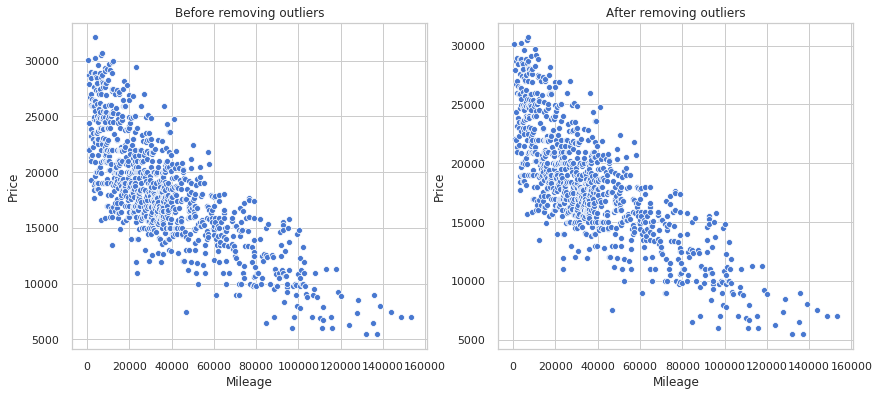

In [67]:
honda_exc_outliers = honda[(cooks_dist_viz.distance_ < 0.005)]
fig = plt.figure(figsize=(14,6))
ax1, ax2 = fig.subplots(1, 2)
sns.scatterplot('Mileage', 'Price', data=honda,ax=ax1)
ax1.set_title('Before removing outliers')
sns.scatterplot('Mileage', 'Price', data=honda_exc_outliers,ax=ax2)
ax2.set_title('After removing outliers');

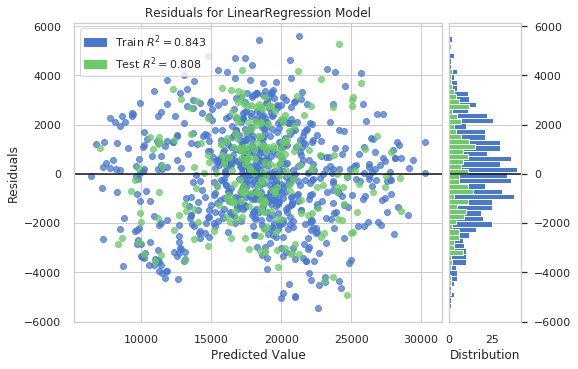

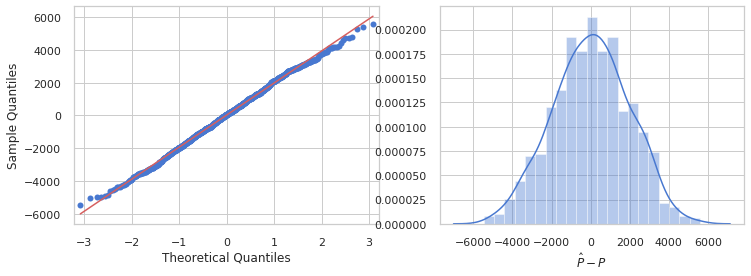

In [68]:
columns = ['Mileage_log', 'Year_ctr_2019', 'EX', 'EXL', 'Sport', 'Touring', 'Price']
model = train_test_plot(honda_exc_outliers,columns)
residuals = model.predict(honda_exc_outliers[columns].drop('Price', axis=1))  -  honda_exc_outliers.Price
fig = plt.figure(figsize=(12,4));axes = fig.subplots(1,2);
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1]);axes[1].set_xlabel('$\hat{P} - P$');

### 2.8 Model performance

In [69]:
result = performance(honda_exc_outliers,['Mileage_std', 'Year_std', 'EX', 'Sport', 'Touring', 'Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [17772.687643955385, 18040.229784610226],
               'mean': 17906.458714282806},
 'R2_on_testset': {'CI': [0.7152531545640938, 0.8059317124094588],
                   'mean': 0.7605924334867763},
 'RMSE': {'CI': [2341.3697194828355, 2347.865527872459],
          'mean': 2344.6176236776473},
 'coef_CI': [(-2000.319791095102, -1743.9220823865783),
             (1994.2864984163039, 2254.547588940069),
             (-339.6750207260626, 74.12514988012705),
             (-107.48545722212249, 294.6912994016752),
             (5035.112425794498, 5804.694034430356)],
 'coef_means': array([-1872.12093674,  2124.41704368,  -132.77493542,    93.60292109,
        5419.90323011])}


In [70]:
result = performance(honda_exc_outliers,['Mileage_log', 'Year_ctr_2019', 'EX', 'EXL', 'Sport', 'Touring', 'Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [37672.54618469668, 39542.2741586514],
               'mean': 38607.41017167404},
 'R2_on_testset': {'CI': [0.8007001596529899, 0.8612525336728833],
                   'mean': 0.8309763466629366},
 'RMSE': {'CI': [1946.0114324696854, 1952.8542609423027],
          'mean': 1949.432846705994},
 'coef_CI': [(-1346.380486590766, -1211.5002611805244),
             (-1160.1827924089457, -1066.123574801578),
             (846.4570018572347, 1289.8319639256663),
             (2701.114588293716, 3066.7207619453666),
             (1270.5886727094594, 1679.2840992797082),
             (6294.341921991275, 6811.809366656323)],
 'coef_means': array([-1278.94037389, -1113.15318361,  1068.14448289,  2883.91767512,
        1474.93638599,  6553.07564432])}


### 2. 9 Final Honda Accord model and 3D plot

In [71]:
honda_model = final_model(result['coef_means'], result['Intercept']['mean'])

print('Final model for Honda Accord: \n\tCoefficients = {} \n\tIntercept = {}'.format(honda_model.coef_, honda_model.intercept_))

Final model for Honda Accord: 
	Coefficients = [-1278.94037389 -1113.15318361  1068.14448289  2883.91767512
  1474.93638599  6553.07564432] 
	Intercept = 38607.41017167404


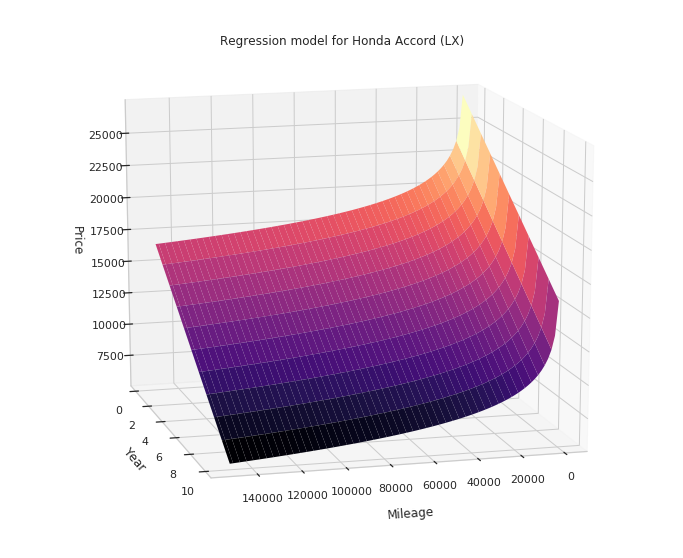

In [72]:
mileage = np.linspace(500, 150000, 100)
year = range(11)

X, Y = np.meshgrid(mileage, year)

Z = f(honda_model, X, Y, 0, 0, 0, 0)
fig = plt.figure(figsize=(12,10))
ax=fig.add_subplot(111,projection='3d')

ax.plot_surface(X,Y,Z, cmap='magma',edgecolor='none')

ax.set_title('Regression model for Honda Accord (LX)');
ax.set_xlabel('\nMileage', linespacing=3.2)
ax.set_ylabel('\nYear')
ax.set_zlabel('\nPrice', linespacing=3.2);
ax.view_init(15, 75)

## 3 Regression model for hyundai Sonata

### 3.1 Initial analysis

In [104]:
hyundai = car_listings[(car_listings.Make == 'Hyundai')].copy()
hyundai.sort_values(by='Mileage', inplace=True)
hyundai.reset_index(inplace=True,drop=True)
hyundai.describe().applymap(lambda x: int(x))

,Year,Price,Mileage
count,743,743,743
mean,2015,14446,41476
std,2,3584,32702
min,2006,2795,5
25%,2015,12995,20532
50%,2016,14900,33047
75%,2017,16582,56281
max,2019,25495,381748


In [0]:
hyundai.drop(hyundai[hyundai.Mileage>2e5].index, inplace=True)

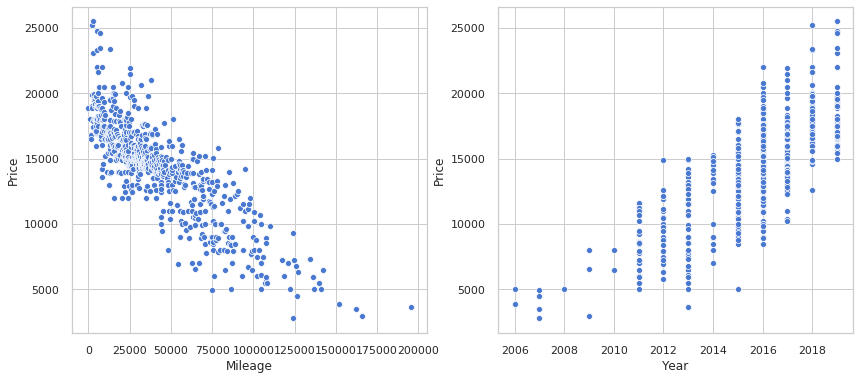

In [108]:
fig = plt.figure(figsize=(14, 6))
ax1, ax2 = fig.subplots(1, 2)
sns.scatterplot('Mileage', 'Price', data=hyundai, ax=ax1)
sns.scatterplot('Year', 'Price', data=hyundai, ax=ax2)

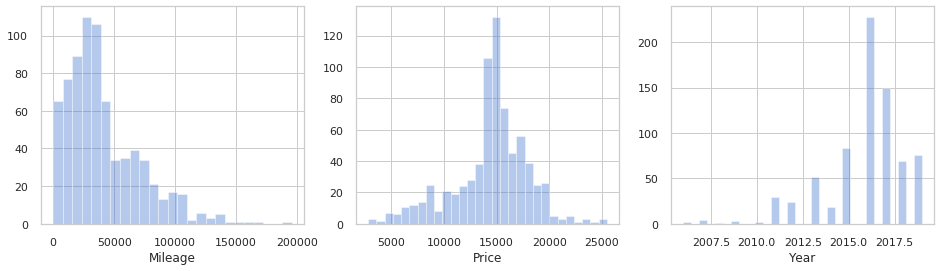

In [109]:
fig = plt.figure(figsize=(16, 4))
axes = fig.subplots(1,3)
sns.distplot(hyundai.Mileage, kde=False, ax=axes[0])
sns.distplot(hyundai.Price, kde=False, ax=axes[1])
sns.distplot(hyundai.Year, kde=False, ax=axes[2])

### 3.2 Trim-levels 

In [110]:
hyundai.groupby('Detailed_model').agg({'Price':['count', 'mean']})

Price              
                                              count          mean
Detailed_model                                                   
2.0T Limited FWD                                  3  16822.666667
Base                                             25  13660.720000
Base 2.4L                                         8  14178.000000
Base PZEV                                        13  13848.461538
Eco                                               6  14964.666667
GLS                                              35  10206.057143
GLS 2.4L                                         17   8485.823529
GLS 2.4L (PZEV)                                   2   7925.000000
GLS 2.4L Automatic                                7   8813.571429
GLS Automatic                                     2   3967.500000
GLS FWD                                           2   7485.000000
GLS FWD Used                                      1   8888.000000
GLS I4 Automatic                                  2   7241.500000
GLS Manual                                        1   4900.000000
GLS PZEV                                         13  10007.000000
GLS V6                                            2   4445.500000
Hybrid Base                                       2   9724.500000
Hybrid Base 2.4L                                  3   8426.666667
Hybrid Limited                                    4  15525.000000
Hybrid SE                                         6  15535.166667
Limited                                          27  15406.259259
Limited 2.0T                                      4  18645.750000
Limited 2.0T w/Black Leather and Gray Accents     4  14674.250000
Limited 2.0T w/Prod. End 5/18                     3  20997.000000
Limited 2.0T with Gray                            2  18025.000000
Limited 2.0T+                                     1  22000.000000
Limited 2.4L                                      9  14532.000000
Limited 2.4L Automatic                            2  10102.500000
Limited FWD                                       2   7497.000000
Limited FWD Used                                  1  14777.000000
Limited I4 Automatic                              1   6509.000000
Limited PZEV                                     28  16661.607143
Limited V6                                        1   7997.000000
Limited w/Brown Leather PZEV                      1  14900.000000
Limited w/Prod. End 5/18                          3  18484.666667
Limited+                                          1  25200.000000
Plug-In Hybrid Base                               1  18900.000000
Plug-In Hybrid Limited                            1  14797.000000
SE                                              172  14861.250000
SE 2.0T                                           3   8205.666667
SE 2.4L                                          35  15550.171429
SE FWD Used                                       2  11947.500000
SE PZEV                                         123  14351.219512
SE SULEV                                          2  17400.000000
SEL                                              14  18791.428571
SEL 2.4L                                          7  17983.571429
SEL FWD                                           2  16199.500000
SEL SULEV w/Prod. End 5/18                        6  17643.500000
SEL w/Prod. End 5/18                              9  16762.444444
Sport                                            40  15572.325000
Sport 2.0T                                       14  15485.571429
Sport 2.0T w/Black Leather and Gray Accents       2  12565.500000
Sport 2.0T with Black                             5  16378.600000
Sport 2.4L                                       15  16522.066667
Sport PZEV                                       38  15620.736842
Sport w/Prod. End 5/18                            2  15893.500000
Sport+                                            3  17197.000000
Used                                              1  12477.000000
V6 SE FWD           

In [134]:
print(hyundai[hyundai.Detailed_model.str.contains('SE',na=False)].Price.count())
print(hyundai[hyundai.Detailed_model.str.contains('Eco',na=False)].Price.count())
print(hyundai[hyundai.Detailed_model.str.contains('SEL',na=False)].Price.count())
print(hyundai[hyundai.Detailed_model.str.contains('Sport',na=False)].Price.count())
print(hyundai[hyundai.Detailed_model.str.contains('Limited',na=False)].Price.count())

382
6
38
119
98


In [133]:
print(hyundai[hyundai.Detailed_model.str.contains('SE',na=False)].Price.mean())
print(hyundai[hyundai.Detailed_model.str.contains('Eco',na=False)].Price.mean())
print(hyundai[hyundai.Detailed_model.str.contains('SEL',na=False)].Price.mean())
print(hyundai[hyundai.Detailed_model.str.contains('Sport',na=False)].Price.mean())
print(hyundai[hyundai.Detailed_model.str.contains('Limited',na=False)].Price.mean())

14981.664921465968
14964.666666666666
17844.394736842107
15726.991596638656
15867.387755102041


### 3.3 Features

In [0]:
hyundai['Year_ctr_2019'] = 2019 - hyundai.Year 
hyundai['Year_std'] = transform(hyundai.Year, 'standardize')
hyundai['Mileage_std'] = transform(hyundai.Mileage, 'standardize')
hyundai['Mileage_log'] = transform(hyundai.Mileage, np.log2)
hyundai['SEL'] = [1 if entry else 0 for entry in hyundai.Detailed_model.str.contains('SEL', na=False)]
hyundai['Sport'] = [1 if entry else 0 for entry in hyundai.Detailed_model.str.contains('Sport', na=False)]
hyundai['Limited'] = [1 if entry else 0 for entry in hyundai.Detailed_model.str.contains('Limited', na=False)]


### 3.4 Linear model

$$P_i = w_0 + w_1 f(M_i) + w_2 g(Y_i) + w_3 1_{\{SEL_i\}} + w_4 1_{\{Sport_i\}} + w_5 1_{\{Limited_i\}},$$

where $M_i$ and $Y_i$ are the *Mileage* and *Year* of the $i^{th}$ car,
$f$ and $g$ are some transformation functions, and $1_{\{a_i\}}$ is an indicator function on condition $a_i$.

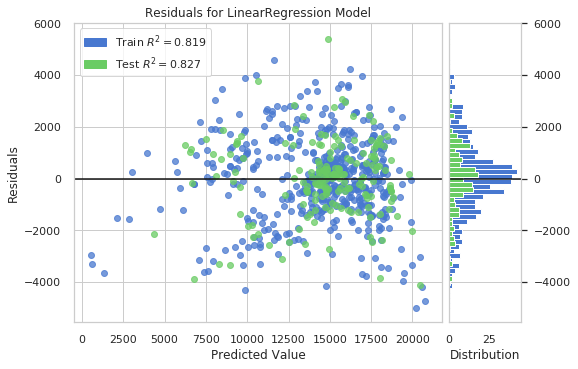

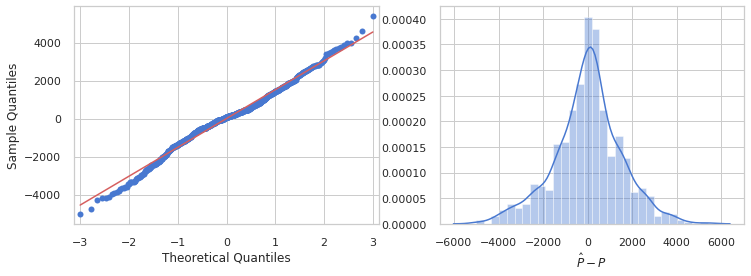

In [127]:
columns = ['Mileage_std', 'Year_std', 'SEL', 'Sport', 'Limited', 'Price']
data = hyundai[columns]
model = train_test_plot(data,columns)
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(12,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
axes[1].set_xlabel('$\hat{P} - P$');

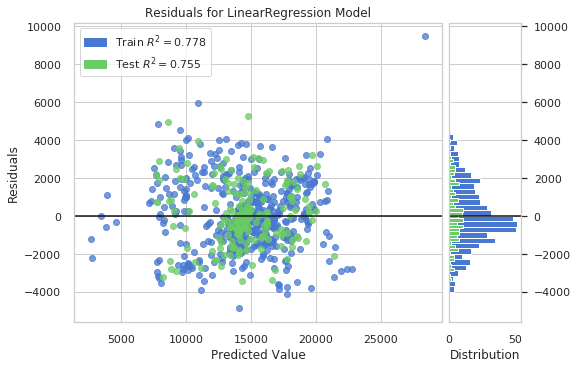

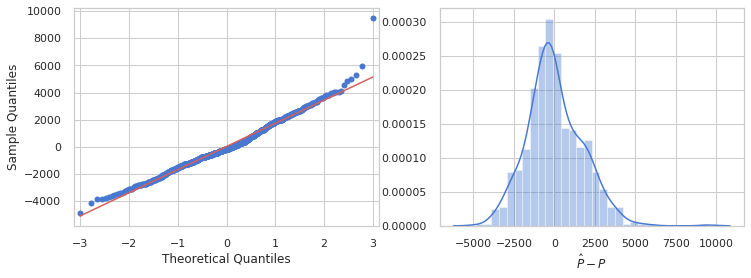

In [120]:
columns = ['Mileage_log', 'Year_ctr_2019', 'SEL', 'Sport', 'Limited', 'Price']
data = hyundai[columns]
model = train_test_plot(data,columns)
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(12,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
axes[1].set_xlabel('$\hat{P} - P$');

### 3.5 Removing influential (outliers) data points using Cook's distance

/usr/local/lib/python3.6/dist-packages/yellowbrick/regressor/influence.py:183: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  self.distance_, linefmt=self.linefmt, markerfmt=self.markerfmt


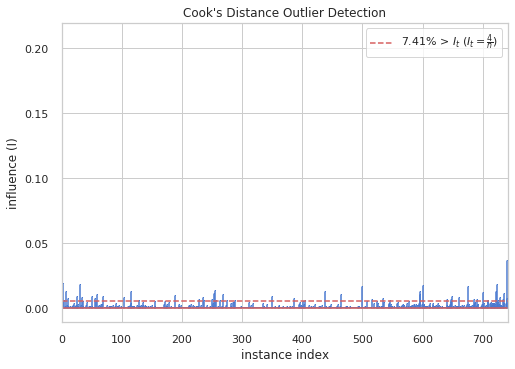

In [121]:
X, y = hyundai[['Mileage_log', 'Year_ctr_2019', 'SEL', 'Sport', 'Limited']], hyundai.Price

# Instantiate and fit the visualizer
cooks_dist_viz = CooksDistance()
cooks_dist_viz.fit(X, y)
cooks_dist_viz.poof()

In [122]:
print(hyundai[cooks_dist_viz.distance_>0.01].shape)
print(hyundai[cooks_dist_viz.distance_<0.01].shape)

(20, 14)
(722, 14)


In [0]:
hyundai_exc_outliers = hyundai[cooks_dist_viz.distance_<0.01]

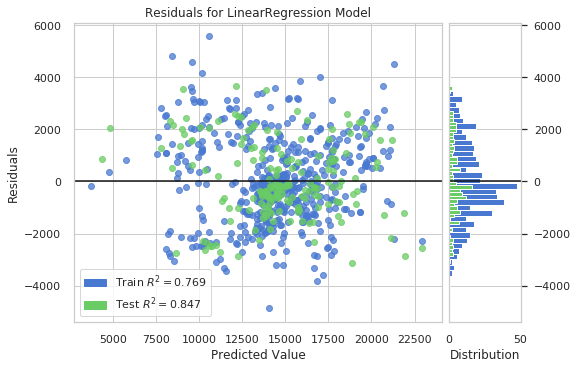

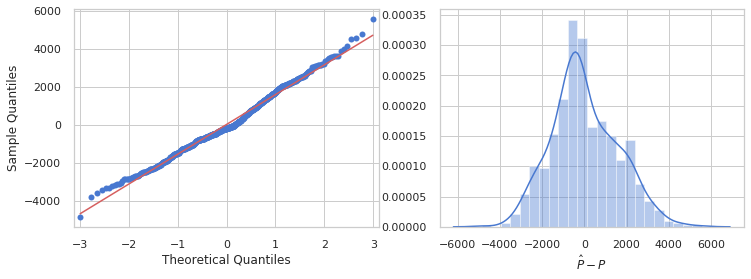

In [131]:
columns = ['Mileage_log', 'Year_ctr_2019', 'SEL', 'Sport', 'Limited', 'Price']
data = hyundai_exc_outliers[columns]
model = train_test_plot(data,columns)
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(12,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
axes[1].set_xlabel('$\hat{P} - P$');

### 3.6 Model performance

In [151]:
result_lin = performance(hyundai_exc_outliers,['Mileage_std', 'Year_std', 'SEL', 'Sport', 'Limited', 'Price'], rep=100, regularizer='e')
pprint(result_lin)

{'Intercept': {'CI': [13862.185529273896, 13996.688320124804],
               'mean': 13929.43692469935},
 'R2_on_testset': {'CI': [0.7779361123001469, 0.8567893827700888],
                   'mean': 0.8173627475351178},
 'RMSE': {'CI': [1437.5440098567278, 1442.988280111092],
          'mean': 1440.26614498391},
 'coef_CI': [(-2031.5389546338774, -1863.9779329756902),
             (1197.4725505090187, 1409.1749688317068),
             (601.0324492787793, 924.7555860630544),
             (938.4309573000173, 1286.0026318030423),
             (2178.483327903561, 2641.35510265386)],
 'coef_means': array([-1947.7584438 ,  1303.32375967,   762.89401767,  1112.21679455,
        2409.91921528])}


In [152]:
result_log = performance(hyundai_exc_outliers,['Mileage_log', 'Year_ctr_2019', 'SEL', 'Sport', 'Limited', 'Price'], rep=100, regularizer='e')
pprint(result_log)

{'Intercept': {'CI': [34195.08182757299, 36652.922747591634],
               'mean': 35424.00228758231},
 'R2_on_testset': {'CI': [0.744613646025338, 0.8291931184605313],
                   'mean': 0.7869033822429347},
 'RMSE': {'CI': [1566.5951693892198, 1574.684230373883],
          'mean': 1570.6396998815515},
 'coef_CI': [(-1376.9948120920242, -1199.2375820173454),
             (-788.126418639469, -696.4819165047813),
             (-82.63596696635696, 184.34085853604736),
             (1165.6276479023943, 1552.4146550506018),
             (2205.2310798588196, 2753.27269174304)],
 'coef_means': array([-1288.11619705,  -742.30416757,    50.85244578,  1359.02115148,
        2479.2518858 ])}


### 3.7 Final model

In [153]:
hyundai_model = final_model(result_log['coef_means'], result_log['Intercept']['mean'])

print('Final model for Hyundai Sonata: \n\tCoefficients = {} \n\tIntercept = {}'.format(hyundai_model.coef_, hyundai_model.intercept_))

Final model for Hyundai Sonata: 
	Coefficients = [-1288.11619705  -742.30416757    50.85244578  1359.02115148
  2479.2518858 ] 
	Intercept = 35424.00228758231


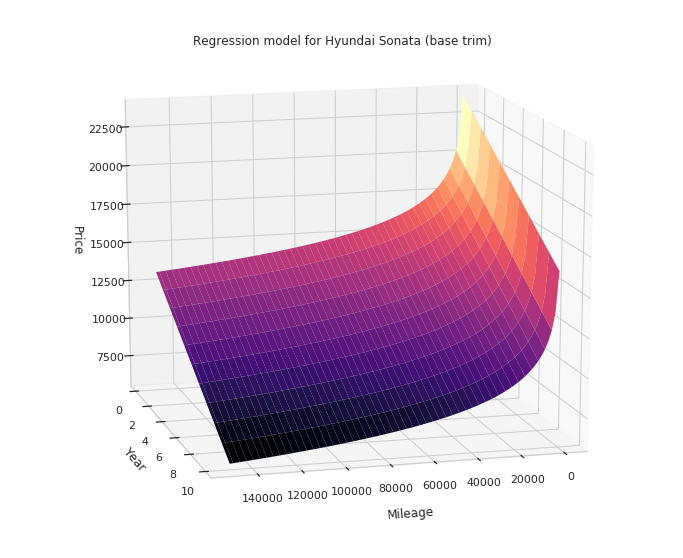

In [141]:
mileage = np.linspace(500, 150000, 100)
year = range(11)

X, Y = np.meshgrid(mileage, year)

Z = f(hyundai_model, X, Y, 0, 0, 0)
fig = plt.figure(figsize=(12,10))
ax=fig.add_subplot(111,projection='3d')

ax.plot_surface(X,Y,Z, cmap='magma',edgecolor='none')

ax.set_title('Regression model for Hyundai Sonata (base trim)');
ax.set_xlabel('\nMileage', linespacing=3.2)
ax.set_ylabel('\nYear')
ax.set_zlabel('\nPrice', linespacing=3.2);
ax.view_init(15, 75)

## 4. Comparing Toyota Camry, Honda Accord and Hyundai Sonata

In [154]:
print(toyota_model)
print(honda_model)
print(hyundai_model)

model(coef_=array([-958.79284499, -988.19889169, 1391.40785864, 4563.77420133,
       2396.15653926]), intercept_=33295.044057096566)
model(coef_=array([-1278.94037389, -1113.15318361,  1068.14448289,  2883.91767512,
        1474.93638599,  6553.07564432]), intercept_=38607.41017167404)
model(coef_=array([-1288.11619705,  -742.30416757,    50.85244578,  1359.02115148,
        2479.2518858 ]), intercept_=35424.00228758231)


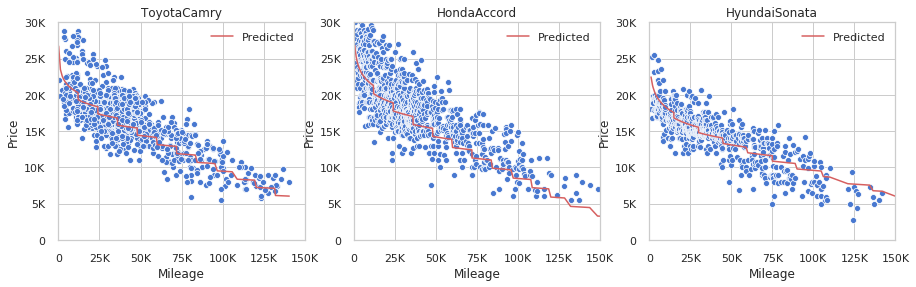

In [181]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, car in zip(axes, ['ToyotaCamry', 'HondaAccord', 'HyundaiSonata']):
  ax.set_xlim(0, 150000)
  ax.set_ylim(0, 30000)
  ax.set_title(car)
  ax.set_xticklabels(['0', '25K', '50K', '75K', '100K', '125K', '150K'])
  ax.set_yticklabels(['0', '5K', '10K', '15K', '20K', '25K', '30K'])
def predict(model, m, y):
  return model.coef_[0] * m + model.coef_[1]*y + model.intercept_
sns.scatterplot('Mileage', 'Price', data=toyota_exc_outliers, ax=axes[0])
sns.lineplot(toyota_exc_outliers.Mileage, predict(toyota_model, toyota_exc_outliers.Mileage_log, toyota_exc_outliers.Mileage // 12000), ax=axes[0], color='r', label='Predicted')

sns.scatterplot('Mileage', 'Price', data=honda_exc_outliers, ax=axes[1])
sns.lineplot(honda_exc_outliers.Mileage, predict(honda_model, honda_exc_outliers.Mileage_log, honda_exc_outliers.Mileage // 12000), ax=axes[1], color='r', label='Predicted')

sns.scatterplot('Mileage', 'Price', data=hyundai_exc_outliers, ax=axes[2])
sns.lineplot(hyundai_exc_outliers.Mileage, predict(hyundai_model, hyundai_exc_outliers.Mileage_log, hyundai_exc_outliers.Mileage // 15000), ax=axes[2], color='r', label='Predicted')

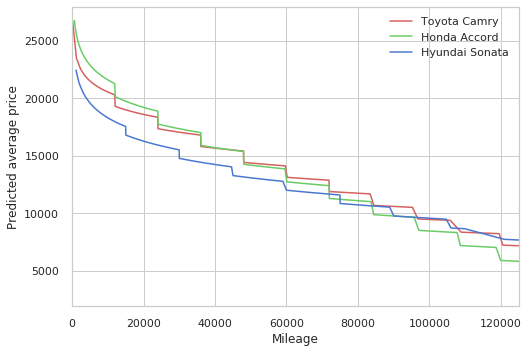

In [190]:
fig, ax = plt.subplots()
ax.set_xlim(0,125000)
ax.set_ylabel('Predicted average price')
sns.lineplot(toyota_exc_outliers.Mileage, predict(toyota_model, toyota_exc_outliers.Mileage_log, toyota_exc_outliers.Mileage // 12000), ax=ax, color='r', label='Toyota Camry')
sns.lineplot(honda_exc_outliers.Mileage, predict(honda_model, honda_exc_outliers.Mileage_log, honda_exc_outliers.Mileage // 12000), ax=ax, color='g', label='Honda Accord')
sns.lineplot(hyundai_exc_outliers.Mileage, predict(hyundai_model, hyundai_exc_outliers.Mileage_log, hyundai_exc_outliers.Mileage // 15000), ax=ax, color='b', label='Hyundai Sonata')